# ALMA project 

### Links of interest 

In [ ]:
#http://www.iainm.com/publications/Lucey2010-The-Extended/paper.pdf
#https://www.kaggle.com/shawon10/ckplus
#https://medium.com/@hinasharma19se/facial-expressions-recognition-b022318d842a
#https://github.com/WuJie1010/Facial-Expression-Recognition.Pytorch
#https://keras.io/layers/convolutional/
#https://www.paralleldots.com/facial-emotion

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
from pathlib import Path

## Make source_images DataFrame 

In [ ]:
def makeImagDf(path):
    dictionary = {}
    for paths in glob.glob(path):
        dictionary.setdefault('sesion', []).append(paths.split('/')[-3])
        dictionary.setdefault('pose', []).append(paths.split('/')[-2])
        dictionary.setdefault('png', []).append(paths.split('/')[-1])
        dictionary.setdefault('path', []).append(paths)
    images = pd.DataFrame(dictionary)
    return images

In [ ]:
data_ima = makeImagDf('source_images/**/**/*.png')

In [ ]:
data_ima['num_foto'] = data_ima['png'].apply(lambda x: x.split('_')[-1])
data_ima['num_foto'] = data_ima['num_foto'].apply(lambda x: int(x.split('.')[-2]))

### Keep only the last three pictures which contain the emotion  

In [ ]:
delet_rows = data_ima.sort_values(by=['sesion', 'pose','num_foto'], ascending=False)

In [ ]:
reduced_photos = pd.DataFrame()

In [ ]:
def selectPhotos(df, sesion, pose, n=3):
    photos_selection = df[df['sesion']==sesion][df['pose']==pose].iloc[:n,:]
    return photos_selection
    
sesion_set = set(delet_rows['sesion'])
pose_set = set(delet_rows['pose'])

for ses in sesion_set: 
    for pos in pose_set: 
        photos_selection = selectPhotos(delet_rows, ses, pos)
        reduced_photos = reduced_photos.append(photos_selection, ignore_index=True)
    

## Make source_emotion DataFrame

In [ ]:
def makeEmoDf(path):
    diction = {}
    for paths in glob.glob(path):
        diction.setdefault('sesion', []).append(paths.split('/')[-3])
        diction.setdefault('pose', []).append(paths.split('/')[-2])
        diction.setdefault('txt', []).append(paths.split('/')[-1])
        diction.setdefault('path', []).append(paths)
    Emotion = pd.DataFrame(diction)
    return Emotion

In [ ]:
data_emo = makeEmoDf('source_emotion/**/**/*.txt')

In [ ]:
lista =[]
for i in data_emo['path']:
    lista.append(open(i, 'r').read())
data_emo['emotion'] = pd.DataFrame(lista)

In [ ]:
data_emo['emotion'] = data_emo['emotion'].apply(lambda x: int(x.strip(' ')[0]))

In [ ]:
def assignEmo(x):
    columns = {'angry':1, 'contempt':2, 'disgust':3, 'fear':4, 'happy':5, 'sadness':6, 'surprise':7} 
    for k,v in columns.items():
        if x == v:
            return k

In [ ]:
data_emo['emotion_name']=data_emo['emotion'].apply(assignEmo)

## Merge both dataframes

Emotions & images

In [ ]:
result = pd.merge(reduced_photos, data_emo, how='left', on=['sesion', 'pose'])

In [ ]:
result.head()

## Drop NaN and reset index

Those Nan correspond to those pictures which are not labeled

In [ ]:
pic_w_emo = result.dropna()

### Drop contempt emotion 

In [ ]:
pic_w_emo.drop(pic_w_emo[pic_w_emo['emotion_name']=='contempt'].index, inplace = True)

In [ ]:
#export_csv = pic_w_emo.to_csv ('pic_w_emo3.csv', index = None, header=True)

In [ ]:
pic_w_emo = pic_w_emo.reset_index(drop=True)

In [ ]:
pic_w_emo.head()

-----------------------------------------------------------------------------------------------------------------

## Transform images

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
def loadImageAsGray(imagePath):
    im = cv2.imread(imagePath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im

In [ ]:
dictionary={}
count = 0
for path in pic_w_emo['path_x']:
    dictionary[count]=loadImageAsGray(path)
    count+=1

In [ ]:
def configImag(array):
    try:
        faces = face_cascade.detectMultiScale(array, 1.25, 6)
        x,y,w,h = faces[0]
        face = array[y:y+h,x:x+w]
        face = cv2.resize(face,(48,48))
        return face
    except:
        return 'face was not found'

In [ ]:
diction={}
for k,v in dictionary.items():
    diction.setdefault('clean_image', []).append(configImag(v))

In [ ]:
pd.DataFrame(diction).shape

In [ ]:
pd.DataFrame(diction).isnull().sum()

In [ ]:
pic_w_emo['arrays']= pd.DataFrame(diction)

In [ ]:
pic_w_emo['arrays'].isnull().sum()

In [ ]:
'''
def transfImag(path):
    img_data_list=[]

    data_dir_list = os.listdir(path)
    for dataset in data_dir_list:
        img_list=os.listdir(path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            try: 
                input_img=cv2.imread(path + '/'+ dataset + '/'+ img )
                input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
                faces = face_cascade.detectMultiScale(input_img, 1.25, 6)
                x,y,w,h = faces[0]
                face = input_img[y:y+h,x:x+w]
                face=cv2.resize(face,(128,128))
                img_data_list.append(face)
            except:
                return 'face was not found'

    img_data = np.stack(img_data_list).astype('uint8')
    return img_data
'''

### Drop those images where the 'face was not found'

In [ ]:
pic_w_emo[pic_w_emo.arrays == 'face was not found']

In [ ]:
pic_w_emo.drop(pic_w_emo[pic_w_emo.arrays == 'face was not found'].index, inplace = True)

In [ ]:
pic_w_emo.head()

## Save the transformed images 

In [ ]:
for index, row in pic_w_emo.iterrows():
    img = Image.fromarray(row['arrays'])
    img.save("sort_set/{}/{}".format(row['emotion_name'],row['png']))

----------------------------------------------------------------------------------------------------------------

## Make sort_set DataFrame 

In [2]:
def makeSortedDf(path):
    dictionary = {}
    for paths in glob.glob(path):
            print(paths)
            dictionary.setdefault('emotion', []).append(paths.split('/')[-2])
            dictionary.setdefault('path', []).append(paths)
            dictionary.setdefault('array', []).append(cv2.imread(paths, cv2.IMREAD_GRAYSCALE))
    images = pd.DataFrame(dictionary)
    return images

In [3]:
#'fer2013/train/**/*.jpg'
#'sort_set/**/*.png'

In [4]:
df_jpg = makeSortedDf('train/**/*.jpg')

train/sadness/14880.jpg
train/sadness/16892.jpg
train/sadness/26501.jpg
train/sadness/07406.jpg
train/sadness/08623.jpg
train/sadness/19864.jpg
train/sadness/21980.jpg
train/sadness/07877.jpg
train/sadness/23884.jpg
train/sadness/15534.jpg
train/sadness/12292.jpg
train/sadness/14277.jpg
train/sadness/05150.jpg
train/sadness/04292.jpg
train/sadness/15727.jpg
train/sadness/07407.jpg
train/sadness/13666.jpg
train/sadness/17748.jpg
train/sadness/20964.jpg
train/sadness/25266.jpg
train/sadness/00098.jpg
train/sadness/11073.jpg
train/sadness/10803.jpg
train/sadness/24007.jpg
train/sadness/21772.jpg
train/sadness/16926.jpg
train/sadness/14193.jpg
train/sadness/04419.jpg
train/sadness/13368.jpg
train/sadness/22861.jpg
train/sadness/27822.jpg
train/sadness/20446.jpg
train/sadness/06312.jpg
train/sadness/18623.jpg
train/sadness/02091.jpg
train/sadness/14049.jpg
train/sadness/26445.jpg
train/sadness/10844.jpg
train/sadness/01208.jpg
train/sadness/25756.jpg
train/sadness/07988.jpg
train/sadness/24

train/sadness/17518.jpg
train/sadness/21492.jpg
train/sadness/21842.jpg
train/sadness/10658.jpg
train/sadness/22416.jpg
train/sadness/14303.jpg
train/sadness/16087.jpg
train/sadness/26378.jpg
train/sadness/12686.jpg
train/sadness/26486.jpg
train/sadness/22715.jpg
train/sadness/28169.jpg
train/sadness/14494.jpg
train/sadness/19535.jpg
train/sadness/23901.jpg
train/sadness/06786.jpg
train/sadness/27762.jpg
train/sadness/04153.jpg
train/sadness/04101.jpg
train/sadness/15499.jpg
train/sadness/25957.jpg
train/sadness/23882.jpg
train/sadness/13253.jpg
train/sadness/17730.jpg
train/sadness/23165.jpg
train/sadness/21504.jpg
train/sadness/14130.jpg
train/sadness/14677.jpg
train/sadness/15024.jpg
train/sadness/06699.jpg
train/sadness/14036.jpg
train/sadness/14106.jpg
train/sadness/18939.jpg
train/sadness/05650.jpg
train/sadness/03864.jpg
train/sadness/09119.jpg
train/sadness/22057.jpg
train/sadness/05128.jpg
train/sadness/23261.jpg
train/sadness/20687.jpg
train/sadness/04167.jpg
train/sadness/13

train/sadness/09267.jpg
train/sadness/03429.jpg
train/sadness/15355.jpg
train/sadness/16932.jpg
train/sadness/02879.jpg
train/sadness/04548.jpg
train/sadness/21409.jpg
train/sadness/07889.jpg
train/sadness/10128.jpg
train/sadness/05606.jpg
train/sadness/22468.jpg
train/sadness/23239.jpg
train/sadness/01557.jpg
train/sadness/06994.jpg
train/sadness/23628.jpg
train/sadness/22413.jpg
train/sadness/13295.jpg
train/sadness/14953.jpg
train/sadness/21949.jpg
train/sadness/19143.jpg
train/sadness/22319.jpg
train/sadness/19838.jpg
train/sadness/16465.jpg
train/sadness/07436.jpg
train/sadness/11510.jpg
train/sadness/05704.jpg
train/sadness/21820.jpg
train/sadness/27357.jpg
train/sadness/07802.jpg
train/sadness/23364.jpg
train/sadness/27540.jpg
train/sadness/24618.jpg
train/sadness/12868.jpg
train/sadness/06354.jpg
train/sadness/04941.jpg
train/sadness/14350.jpg
train/sadness/19825.jpg
train/sadness/12331.jpg
train/sadness/01852.jpg
train/sadness/02526.jpg
train/sadness/17323.jpg
train/sadness/19

train/sadness/22752.jpg
train/sadness/06660.jpg
train/sadness/23558.jpg
train/sadness/03840.jpg
train/sadness/09658.jpg
train/sadness/15407.jpg
train/sadness/20661.jpg
train/sadness/06460.jpg
train/sadness/18571.jpg
train/sadness/19169.jpg
train/sadness/15565.jpg
train/sadness/26208.jpg
train/sadness/11209.jpg
train/sadness/25700.jpg
train/sadness/01686.jpg
train/sadness/05336.jpg
train/sadness/23965.jpg
train/sadness/01009.jpg
train/sadness/11388.jpg
train/sadness/26510.jpg
train/sadness/13812.jpg
train/sadness/14823.jpg
train/sadness/08237.jpg
train/sadness/22788.jpg
train/sadness/23407.jpg
train/sadness/11582.jpg
train/sadness/00127.jpg
train/sadness/23509.jpg
train/sadness/20509.jpg
train/sadness/09596.jpg
train/sadness/07479.jpg
train/sadness/21040.jpg
train/sadness/10808.jpg
train/sadness/25448.jpg
train/sadness/08604.jpg
train/sadness/15146.jpg
train/sadness/12823.jpg
train/sadness/15734.jpg
train/sadness/24998.jpg
train/sadness/28031.jpg
train/sadness/17943.jpg
train/sadness/19

train/happy/12779.jpg
train/happy/28262.jpg
train/happy/14355.jpg
train/happy/16239.jpg
train/happy/15379.jpg
train/happy/19968.jpg
train/happy/19098.jpg
train/happy/20735.jpg
train/happy/19747.jpg
train/happy/21267.jpg
train/happy/27073.jpg
train/happy/23015.jpg
train/happy/14451.jpg
train/happy/22663.jpg
train/happy/21006.jpg
train/happy/24290.jpg
train/happy/15646.jpg
train/happy/19547.jpg
train/happy/27807.jpg
train/happy/27615.jpg
train/happy/15899.jpg
train/happy/24153.jpg
train/happy/24563.jpg
train/happy/20378.jpg
train/happy/11081.jpg
train/happy/14514.jpg
train/happy/18822.jpg
train/happy/19839.jpg
train/happy/28044.jpg
train/happy/22225.jpg
train/happy/17383.jpg
train/happy/25653.jpg
train/happy/12983.jpg
train/happy/17458.jpg
train/happy/00378.jpg
train/happy/14597.jpg
train/happy/25051.jpg
train/happy/24741.jpg
train/happy/24043.jpg
train/happy/20142.jpg
train/happy/11553.jpg
train/happy/22044.jpg
train/happy/11871.jpg
train/happy/16086.jpg
train/happy/13428.jpg
train/happ

train/happy/24823.jpg
train/happy/08089.jpg
train/happy/15872.jpg
train/happy/12317.jpg
train/happy/00453.jpg
train/happy/21439.jpg
train/happy/24135.jpg
train/happy/28105.jpg
train/happy/27460.jpg
train/happy/14568.jpg
train/happy/25366.jpg
train/happy/20377.jpg
train/happy/22223.jpg
train/happy/08018.jpg
train/happy/14589.jpg
train/happy/09402.jpg
train/happy/11078.jpg
train/happy/00008.jpg
train/happy/28474.jpg
train/happy/18283.jpg
train/happy/18424.jpg
train/happy/18033.jpg
train/happy/20848.jpg
train/happy/10248.jpg
train/happy/27371.jpg
train/happy/20945.jpg
train/happy/22428.jpg
train/happy/15186.jpg
train/happy/08256.jpg
train/happy/19817.jpg
train/happy/20207.jpg
train/happy/19679.jpg
train/happy/22388.jpg
train/happy/27929.jpg
train/happy/21861.jpg
train/happy/11772.jpg
train/happy/17821.jpg
train/happy/18250.jpg
train/happy/20334.jpg
train/happy/14245.jpg
train/happy/18153.jpg
train/happy/24932.jpg
train/happy/12589.jpg
train/happy/26766.jpg
train/happy/20607.jpg
train/happ

train/happy/21098.jpg
train/happy/13144.jpg
train/happy/20271.jpg
train/happy/25063.jpg
train/happy/23804.jpg
train/happy/17071.jpg
train/happy/08322.jpg
train/happy/19062.jpg
train/happy/08447.jpg
train/happy/13502.jpg
train/happy/25332.jpg
train/happy/27186.jpg
train/happy/24158.jpg
train/happy/08745.jpg
train/happy/15781.jpg
train/happy/10641.jpg
train/happy/22188.jpg
train/happy/14590.jpg
train/happy/21982.jpg
train/happy/14799.jpg
train/happy/21979.jpg
train/happy/19499.jpg
train/happy/21177.jpg
train/happy/27844.jpg
train/happy/00417.jpg
train/happy/21291.jpg
train/happy/26284.jpg
train/happy/11743.jpg
train/happy/21143.jpg
train/happy/12281.jpg
train/happy/24271.jpg
train/happy/16198.jpg
train/happy/18907.jpg
train/happy/27671.jpg
train/happy/09516.jpg
train/happy/24235.jpg
train/happy/27487.jpg
train/happy/19465.jpg
train/happy/23472.jpg
train/happy/22966.jpg
train/happy/17483.jpg
train/happy/14973.jpg
train/happy/27086.jpg
train/happy/22911.jpg
train/happy/26648.jpg
train/happ

train/neutral/17585.jpg
train/neutral/14983.jpg
train/neutral/24794.jpg
train/neutral/21894.jpg
train/neutral/15337.jpg
train/neutral/25615.jpg
train/neutral/00917.jpg
train/neutral/22480.jpg
train/neutral/20690.jpg
train/neutral/26081.jpg
train/neutral/08023.jpg
train/neutral/10041.jpg
train/neutral/01080.jpg
train/neutral/05643.jpg
train/neutral/07399.jpg
train/neutral/19333.jpg
train/neutral/14079.jpg
train/neutral/21794.jpg
train/neutral/06718.jpg
train/neutral/09970.jpg
train/neutral/28485.jpg
train/neutral/22815.jpg
train/neutral/08757.jpg
train/neutral/25449.jpg
train/neutral/14711.jpg
train/neutral/17922.jpg
train/neutral/21551.jpg
train/neutral/17931.jpg
train/neutral/19479.jpg
train/neutral/15445.jpg
train/neutral/17980.jpg
train/neutral/28617.jpg
train/neutral/19955.jpg
train/neutral/10204.jpg
train/neutral/21761.jpg
train/neutral/20489.jpg
train/neutral/21862.jpg
train/neutral/24248.jpg
train/neutral/19340.jpg
train/neutral/26883.jpg
train/neutral/04069.jpg
train/neutral/11

train/neutral/14150.jpg
train/neutral/24347.jpg
train/neutral/11064.jpg
train/neutral/04161.jpg
train/neutral/22646.jpg
train/neutral/22873.jpg
train/neutral/16427.jpg
train/neutral/04166.jpg
train/neutral/18223.jpg
train/neutral/04968.jpg
train/neutral/06613.jpg
train/neutral/00905.jpg
train/neutral/03371.jpg
train/neutral/09669.jpg
train/neutral/16989.jpg
train/neutral/22579.jpg
train/neutral/18946.jpg
train/neutral/24365.jpg
train/neutral/25376.jpg
train/neutral/15362.jpg
train/neutral/03623.jpg
train/neutral/21262.jpg
train/neutral/05980.jpg
train/neutral/04247.jpg
train/neutral/09243.jpg
train/neutral/12215.jpg
train/neutral/11248.jpg
train/neutral/13710.jpg
train/neutral/21043.jpg
train/neutral/00567.jpg
train/neutral/08976.jpg
train/neutral/19071.jpg
train/neutral/02223.jpg
train/neutral/13340.jpg
train/neutral/26639.jpg
train/neutral/07696.jpg
train/neutral/11499.jpg
train/neutral/03014.jpg
train/neutral/22698.jpg
train/neutral/07611.jpg
train/neutral/25148.jpg
train/neutral/22

train/neutral/09987.jpg
train/neutral/00243.jpg
train/neutral/25009.jpg
train/neutral/04709.jpg
train/neutral/18973.jpg
train/neutral/16363.jpg
train/neutral/12013.jpg
train/neutral/03809.jpg
train/neutral/20819.jpg
train/neutral/01744.jpg
train/neutral/20588.jpg
train/neutral/06710.jpg
train/neutral/01569.jpg
train/neutral/13908.jpg
train/neutral/22734.jpg
train/neutral/22180.jpg
train/neutral/19729.jpg
train/neutral/28681.jpg
train/neutral/22938.jpg
train/neutral/23742.jpg
train/neutral/12933.jpg
train/neutral/26017.jpg
train/neutral/14850.jpg
train/neutral/11823.jpg
train/neutral/01692.jpg
train/neutral/22402.jpg
train/neutral/06148.jpg
train/neutral/12289.jpg
train/neutral/02673.jpg
train/neutral/17946.jpg
train/neutral/23039.jpg
train/neutral/27802.jpg
train/neutral/11498.jpg
train/neutral/24964.jpg
train/neutral/08491.jpg
train/neutral/26049.jpg
train/neutral/15652.jpg
train/neutral/28423.jpg
train/neutral/13290.jpg
train/neutral/27882.jpg
train/neutral/01656.jpg
train/neutral/28

train/neutral/16831.jpg
train/neutral/26209.jpg
train/neutral/22246.jpg
train/neutral/18923.jpg
train/neutral/07227.jpg
train/neutral/17466.jpg
train/neutral/00570.jpg
train/neutral/20728.jpg
train/neutral/22974.jpg
train/neutral/24358.jpg
train/neutral/12882.jpg
train/neutral/13576.jpg
train/neutral/18447.jpg
train/neutral/26012.jpg
train/neutral/21393.jpg
train/neutral/05381.jpg
train/neutral/12883.jpg
train/neutral/03156.jpg
train/neutral/20549.jpg
train/neutral/02737.jpg
train/neutral/12411.jpg
train/neutral/26453.jpg
train/neutral/08842.jpg
train/neutral/05684.jpg
train/neutral/19951.jpg
train/neutral/26041.jpg
train/neutral/16051.jpg
train/neutral/19525.jpg
train/neutral/26924.jpg
train/neutral/20554.jpg
train/neutral/20572.jpg
train/neutral/02401.jpg
train/neutral/01383.jpg
train/neutral/06857.jpg
train/neutral/06688.jpg
train/neutral/15740.jpg
train/neutral/08854.jpg
train/neutral/12682.jpg
train/neutral/27600.jpg
train/neutral/15568.jpg
train/neutral/05869.jpg
train/neutral/11

train/angry/03819.jpg
train/angry/15902.jpg
train/angry/23632.jpg
train/angry/26625.jpg
train/angry/24819.jpg
train/angry/06259.jpg
train/angry/08961.jpg
train/angry/26664.jpg
train/angry/26439.jpg
train/angry/05832.jpg
train/angry/02498.jpg
train/angry/26714.jpg
train/angry/15739.jpg
train/angry/21173.jpg
train/angry/17881.jpg
train/angry/26396.jpg
train/angry/05459.jpg
train/angry/18048.jpg
train/angry/05400.jpg
train/angry/15482.jpg
train/angry/14667.jpg
train/angry/26894.jpg
train/angry/22234.jpg
train/angry/14029.jpg
train/angry/09782.jpg
train/angry/20458.jpg
train/angry/08271.jpg
train/angry/15928.jpg
train/angry/05505.jpg
train/angry/27512.jpg
train/angry/08273.jpg
train/angry/11694.jpg
train/angry/24345.jpg
train/angry/26549.jpg
train/angry/09583.jpg
train/angry/04665.jpg
train/angry/00421.jpg
train/angry/28601.jpg
train/angry/23857.jpg
train/angry/28148.jpg
train/angry/11922.jpg
train/angry/18139.jpg
train/angry/25680.jpg
train/angry/11113.jpg
train/angry/17000.jpg
train/angr

train/angry/14083.jpg
train/angry/03091.jpg
train/angry/08767.jpg
train/angry/17222.jpg
train/angry/13978.jpg
train/angry/27798.jpg
train/angry/18439.jpg
train/angry/25740.jpg
train/angry/26881.jpg
train/angry/08092.jpg
train/angry/15112.jpg
train/angry/10142.jpg
train/angry/13499.jpg
train/angry/04707.jpg
train/angry/24678.jpg
train/angry/00883.jpg
train/angry/06674.jpg
train/angry/03467.jpg
train/angry/00835.jpg
train/angry/02054.jpg
train/angry/26168.jpg
train/angry/07004.jpg
train/angry/09802.jpg
train/angry/14381.jpg
train/angry/01370.jpg
train/angry/11083.jpg
train/angry/03482.jpg
train/angry/07811.jpg
train/angry/18671.jpg
train/angry/03151.jpg
train/angry/15418.jpg
train/angry/22024.jpg
train/angry/07655.jpg
train/angry/01106.jpg
train/angry/27482.jpg
train/angry/10287.jpg
train/angry/13781.jpg
train/angry/11929.jpg
train/angry/27838.jpg
train/angry/10440.jpg
train/angry/22516.jpg
train/angry/20033.jpg
train/angry/22339.jpg
train/angry/22187.jpg
train/angry/27113.jpg
train/angr

train/fear/19634.jpg
train/fear/06649.jpg
train/fear/20282.jpg
train/fear/01496.jpg
train/fear/05222.jpg
train/fear/01366.jpg
train/fear/23503.jpg
train/fear/05911.jpg
train/fear/12491.jpg
train/fear/01741.jpg
train/fear/00983.jpg
train/fear/16915.jpg
train/fear/03197.jpg
train/fear/00579.jpg
train/fear/23926.jpg
train/fear/23594.jpg
train/fear/07393.jpg
train/fear/06461.jpg
train/fear/26048.jpg
train/fear/00669.jpg
train/fear/22875.jpg
train/fear/18407.jpg
train/fear/25998.jpg
train/fear/12898.jpg
train/fear/23161.jpg
train/fear/04189.jpg
train/fear/06768.jpg
train/fear/18637.jpg
train/fear/14797.jpg
train/fear/02760.jpg
train/fear/13807.jpg
train/fear/21020.jpg
train/fear/16191.jpg
train/fear/27363.jpg
train/fear/17832.jpg
train/fear/12858.jpg
train/fear/04901.jpg
train/fear/06650.jpg
train/fear/12240.jpg
train/fear/04401.jpg
train/fear/01343.jpg
train/fear/12020.jpg
train/fear/25536.jpg
train/fear/07933.jpg
train/fear/25872.jpg
train/fear/23649.jpg
train/fear/26547.jpg
train/fear/11

train/fear/02644.jpg
train/fear/14403.jpg
train/fear/22377.jpg
train/fear/13690.jpg
train/fear/19305.jpg
train/fear/18317.jpg
train/fear/10075.jpg
train/fear/23950.jpg
train/fear/16168.jpg
train/fear/13946.jpg
train/fear/07478.jpg
train/fear/10507.jpg
train/fear/12986.jpg
train/fear/15574.jpg
train/fear/03124.jpg
train/fear/03428.jpg
train/fear/06030.jpg
train/fear/17631.jpg
train/fear/16865.jpg
train/fear/05354.jpg
train/fear/11906.jpg
train/fear/01884.jpg
train/fear/12223.jpg
train/fear/26969.jpg
train/fear/01474.jpg
train/fear/22929.jpg
train/fear/24782.jpg
train/fear/14984.jpg
train/fear/28189.jpg
train/fear/01169.jpg
train/fear/28036.jpg
train/fear/22430.jpg
train/fear/22304.jpg
train/fear/15041.jpg
train/fear/10822.jpg
train/fear/05670.jpg
train/fear/02553.jpg
train/fear/25711.jpg
train/fear/24520.jpg
train/fear/24098.jpg
train/fear/17026.jpg
train/fear/21420.jpg
train/fear/05533.jpg
train/fear/27935.jpg
train/fear/24206.jpg
train/fear/04444.jpg
train/fear/16536.jpg
train/fear/22

train/fear/21717.jpg
train/fear/04785.jpg
train/fear/16202.jpg
train/fear/12360.jpg
train/fear/24082.jpg
train/fear/13654.jpg
train/fear/13616.jpg
train/fear/14570.jpg
train/fear/03848.jpg
train/fear/26876.jpg
train/fear/13678.jpg
train/fear/27310.jpg
train/fear/22917.jpg
train/fear/05858.jpg
train/fear/04688.jpg
train/fear/13122.jpg
train/fear/03914.jpg
train/fear/04446.jpg
train/fear/09346.jpg
train/fear/16486.jpg
train/fear/21454.jpg
train/fear/15586.jpg
train/fear/11185.jpg
train/fear/05180.jpg
train/fear/24267.jpg
train/fear/16804.jpg
train/fear/10335.jpg
train/fear/22884.jpg
train/fear/14664.jpg
train/fear/03640.jpg
train/fear/09544.jpg
train/fear/21269.jpg
train/fear/04990.jpg
train/fear/16986.jpg
train/fear/23371.jpg
train/fear/13683.jpg
train/fear/19070.jpg
train/fear/16814.jpg
train/fear/01634.jpg
train/fear/05126.jpg
train/fear/24282.jpg
train/fear/12828.jpg
train/fear/07641.jpg
train/fear/15673.jpg
train/fear/20212.jpg
train/fear/24525.jpg
train/fear/14987.jpg
train/fear/19

train/surprise/27243.jpg
train/surprise/26467.jpg
train/surprise/24985.jpg
train/surprise/20515.jpg
train/surprise/22135.jpg
train/surprise/28068.jpg
train/surprise/09961.jpg
train/surprise/26485.jpg
train/surprise/15808.jpg
train/surprise/02566.jpg
train/surprise/16976.jpg
train/surprise/22982.jpg
train/surprise/27666.jpg
train/surprise/28237.jpg
train/surprise/21365.jpg
train/surprise/07434.jpg
train/surprise/25114.jpg
train/surprise/08683.jpg
train/surprise/24904.jpg
train/surprise/25299.jpg
train/surprise/20537.jpg
train/surprise/05771.jpg
train/surprise/19389.jpg
train/surprise/18635.jpg
train/surprise/21044.jpg
train/surprise/05981.jpg
train/surprise/00345.jpg
train/surprise/01033.jpg
train/surprise/22106.jpg
train/surprise/06564.jpg
train/surprise/10932.jpg
train/surprise/24103.jpg
train/surprise/06716.jpg
train/surprise/21382.jpg
train/surprise/12624.jpg
train/surprise/21355.jpg
train/surprise/01376.jpg
train/surprise/00155.jpg
train/surprise/12358.jpg
train/surprise/17019.jpg


train/surprise/22518.jpg
train/surprise/08468.jpg
train/surprise/16161.jpg
train/surprise/16337.jpg
train/surprise/01952.jpg
train/surprise/08137.jpg
train/surprise/26787.jpg
train/surprise/20139.jpg
train/surprise/11737.jpg
train/surprise/24553.jpg
train/surprise/16721.jpg
train/surprise/26800.jpg
train/surprise/10473.jpg
train/surprise/05609.jpg
train/surprise/04636.jpg
train/surprise/01859.jpg
train/surprise/12135.jpg
train/surprise/17540.jpg
train/surprise/05003.jpg
train/surprise/18170.jpg
train/surprise/00751.jpg
train/surprise/28326.jpg
train/surprise/03354.jpg
train/surprise/19556.jpg
train/surprise/26086.jpg
train/surprise/27774.jpg
train/surprise/03550.jpg
train/surprise/17322.jpg
train/surprise/03040.jpg
train/surprise/15416.jpg
train/surprise/10408.jpg
train/surprise/04613.jpg
train/surprise/22525.jpg
train/surprise/22658.jpg
train/surprise/19920.jpg
train/surprise/27664.jpg
train/surprise/20444.jpg
train/surprise/14579.jpg
train/surprise/04595.jpg
train/surprise/09882.jpg


In [5]:
df_jpg.shape

(27066, 3)

In [6]:
df_png = makeSortedDf('train/**/*.png')

train/sadness/S071_002_00000020.png
train/sadness/S130_009_00000019.png
train/sadness/S125_001_00000012.png
train/sadness/S071_002_00000018.png
train/sadness/S106_002_00000015.png
train/sadness/S115_004_00000016.png
train/sadness/S504_006_00000016.png
train/sadness/S081_002_00000024.png
train/sadness/S505_006_00000017.png
train/sadness/S506_006_00000042.png
train/sadness/S137_005_00000027.png
train/sadness/S064_004_00000012.png
train/sadness/S042_002_00000016.png
train/sadness/S115_004_00000017.png
train/sadness/S506_006_00000040.png
train/sadness/S501_006_00000039.png
train/sadness/S081_002_00000022.png
train/sadness/S108_005_00000022.png
train/sadness/S042_002_00000015.png
train/sadness/S093_001_00000019.png
train/sadness/S064_004_00000013.png
train/sadness/S138_007_00000009.png
train/sadness/S014_002_00000014.png
train/sadness/S064_004_00000014.png
train/sadness/S080_005_00000011.png
train/sadness/S113_003_00000015.png
train/sadness/S503_006_00000018.png
train/sadness/S046_001_00000

In [7]:
df_png.shape

(929, 3)

In [8]:
frames = [df_png , df_jpg]
result = pd.concat(frames)

In [9]:
result.head()

,emotion,path,array
0,sadness,train/sadness/S071_002_00000020.png,"[[84, 85, 84, 85, 86, 87, 84, 82, 33, 25, 28, ..."
1,sadness,train/sadness/S130_009_00000019.png,"[[58, 34, 29, 12, 0, 0, 0, 0, 1, 0, 0, 1, 25, ..."
2,sadness,train/sadness/S125_001_00000012.png,"[[157, 129, 46, 45, 42, 43, 36, 32, 24, 29, 24..."
3,sadness,train/sadness/S071_002_00000018.png,"[[85, 85, 85, 86, 84, 83, 84, 79, 40, 24, 27, ..."
4,sadness,train/sadness/S106_002_00000015.png,"[[76, 75, 76, 81, 35, 34, 33, 35, 45, 39, 29, ..."


In [20]:
result['emotion'].value_counts()

happy       5676
neutral     4960
sadness     4911
fear        4172
angry       4130
surprise    3422
disgust      724
Name: emotion, dtype: int64

In [10]:
result.iloc[24652]

emotion                                                 fear
path                                    train/fear/15503.jpg
array      [[244, 255, 214, 88, 73, 79, 81, 63, 53, 79, 9...
Name: 23723, dtype: object

In [11]:
#df_complete.drop(df_complete[df_complete['arrays'].isnull()].index, inplace = True)

In [12]:
#df_complete.to_pickle("./w_arraydef.pkl")

In [13]:
result.shape

(27995, 3)

In [14]:
result = result.reset_index(drop=True)

## Get dummies to get an array of classes 

In [15]:
new= pd.get_dummies(result['emotion'])

In [16]:
new.shape

(27995, 7)

In [17]:
data_new=result.join(new)

In [18]:
data_new.emotion.unique()

array(['sadness', 'happy', 'disgust', 'angry', 'fear', 'surprise',
       'neutral'], dtype=object)

In [19]:
data_new['gt'] = data_new[['angry','disgust','fear','happy','sadness','surprise','neutral']].apply(lambda x: pd.Series([x.values]), axis=1)

In [ ]:
data_new.head()

### Testing the arrays are surely an image

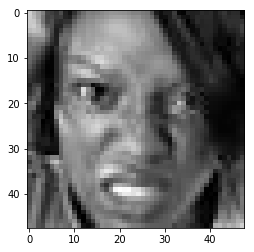

In [21]:
plt.imshow(data_new['array'][21000], cmap="gray")

### Data_new to pickle 

In [22]:
data_new.to_pickle("./toTrain.pkl")

## Just in case

In [ ]:
'''
def imagDataset(path):
    allim = []
    for im in glob.glob(f"./{path}/*/*"):
        allim.append(cv2.imread(im))
    return allim

data_new['arraysRe']= imagDataset('sorted_set')
'''

In [ ]:
'''
def emoDataset(path):
    allemo =[]
    for emo in glob.glob(f"./{path}/*/*"):
        allemo.append(emo.split('/')[-2])
    return allemo
'''